In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
plt.style.use('seaborn')

In [2]:
results = pd.read_csv(r'data/results.csv')
races = pd.read_csv(r'data/races.csv')
quali = pd.read_csv(r'data/qualifying.csv')
drivers = pd.read_csv(r'data/drivers.csv')
constructors = pd.read_csv(r'data/constructors.csv')
circuit = pd.read_csv(r'data/circuits.csv')

In [3]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])

/var/folders/2p/jls_kbks2ps5z7245h_g4blm0000gn/T/ipykernel_6264/1817602468.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])


In [4]:
df1.dtypes

raceId               int64
year                 int64
round                int64
circuitId            int64
name                object
date                object
time_x              object
url                 object
resultId             int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time_y              object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object

In [5]:
#Önemli olmayan sütunları dropluyorz
data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1'],1)

/var/folders/2p/jls_kbks2ps5z7245h_g4blm0000gn/T/ipykernel_6264/880566993.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',


In [6]:
results.head(10) 

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1
5,6,18,6,3,8,13,6,6,6,3.0,57,\N,\N,50,14,1:29.639,212.974,11
6,7,18,7,5,14,17,7,7,7,2.0,55,\N,\N,22,12,1:29.534,213.224,5
7,8,18,8,6,1,15,8,8,8,1.0,53,\N,\N,20,4,1:27.903,217.180,5
8,9,18,9,2,4,2,\N,R,9,0.0,47,\N,\N,15,9,1:28.753,215.100,4
9,10,18,10,7,12,18,\N,R,10,0.0,43,\N,\N,23,13,1:29.558,213.166,3


F1 yapısı gereği değişiktir. Dolayısıyla takımların isimleri değişir, pilotlar takım değiştirir,emekli olurlar ya da ceşitli sebeplerden ötürü bazı yarışları kaçırırlar.

In [7]:
races.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [8]:
drivers.head

<bound method NDFrame.head of      driverId   driverRef number code   forename     surname         dob  \
0           1    hamilton     44  HAM      Lewis    Hamilton  1985-01-07   
1           2    heidfeld     \N  HEI       Nick    Heidfeld  1977-05-10   
2           3     rosberg      6  ROS       Nico     Rosberg  1985-06-27   
3           4      alonso     14  ALO   Fernando      Alonso  1981-07-29   
4           5  kovalainen     \N  KOV     Heikki  Kovalainen  1981-10-19   
..        ...         ...    ...  ...        ...         ...         ...   
843       845    sirotkin     35  SIR     Sergey    Sirotkin  1995-08-27   
844       846      norris      4  NOR      Lando      Norris  1999-11-13   
845       847     russell     63  RUS     George     Russell  1998-02-15   
846       848       albon     23  ALB  Alexander       Albon  1996-03-23   
847       849      latifi      6  LAT   Nicholas      Latifi  1995-06-29   

    nationality                                          

In [9]:
#2010'dan beri olan puanlara bakalım.
data = data[data['year']>=2010]

In [10]:
#bazı sütunların adlarını değiştirelim
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [11]:
#pilot yaşı parametresi oluşturalım
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

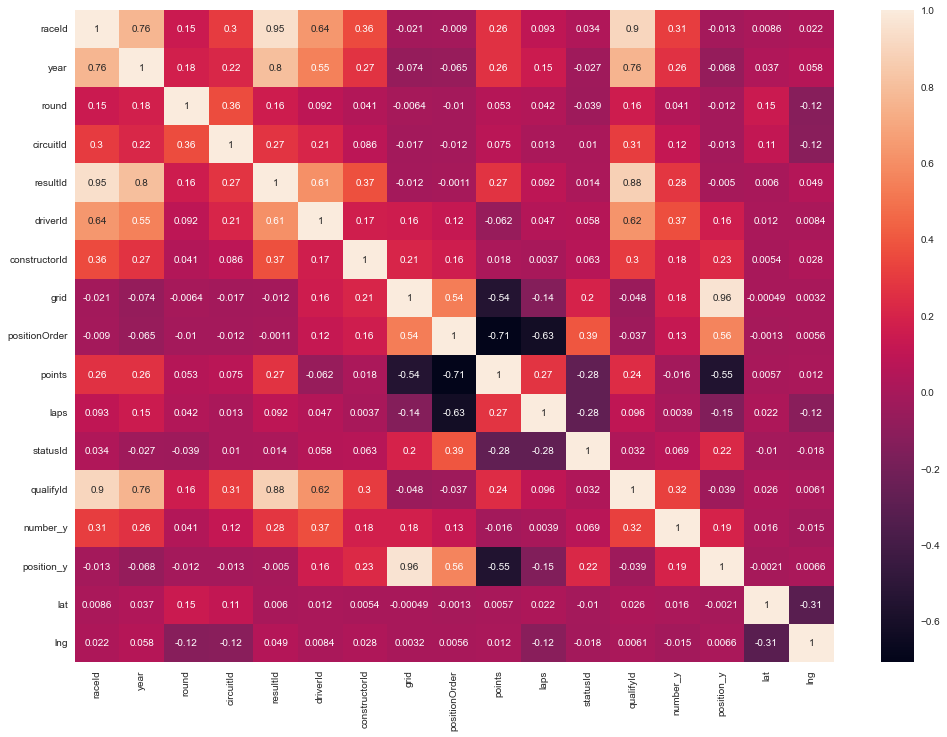

In [12]:
#Isı haritası
plt.figure(figsize=(17,12))
sns.heatmap(df5.corr(),annot=True)
plt.show()

In [13]:
#Bazı takımların adları değişti dolayısıyla onları yeni adlarıyla değiştirelim.
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [14]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

Text(0.5, 0, 'Year')

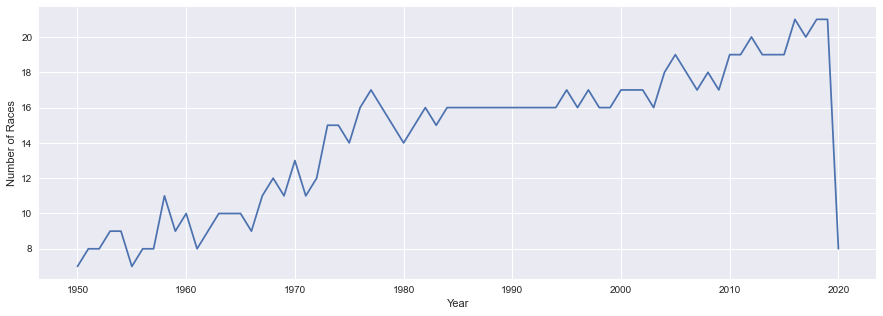

In [15]:
#Yıllara göre yarış sayısı
rounds = races.groupby('year').round.max().reset_index()['round'].tolist()
years = races.groupby('year').round.max().reset_index()['year'].tolist()

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(years, rounds)

ax.set_ylabel("Number of Races")
ax.set_xlabel("Year")


Text(0, 0.5, 'Number of circuit')

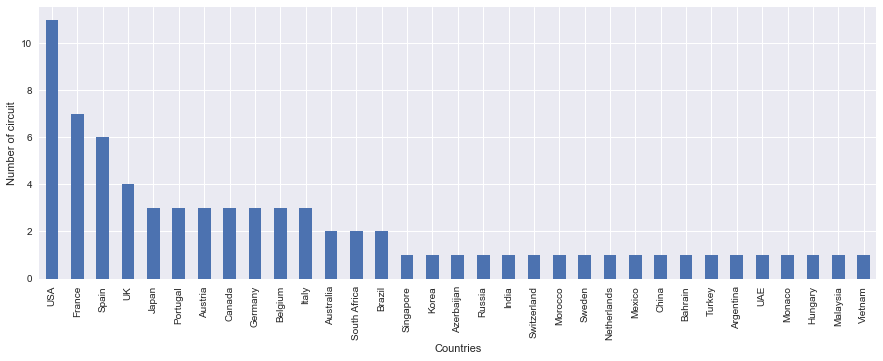

In [16]:
#Ülkelerdeki pist sayıları
fig, ax = plt.subplots(figsize=(15,5))

circuit['country'].value_counts().plot.bar(ax=ax)

ax.set_xlabel("Countries")
ax.set_ylabel("Number of circuit")

In [17]:
#Neden DNF oldular
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],1,inplace=True)

/var/folders/2p/jls_kbks2ps5z7245h_g4blm0000gn/T/ipykernel_6264/1350688427.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['forename','surname'],1,inplace=True)


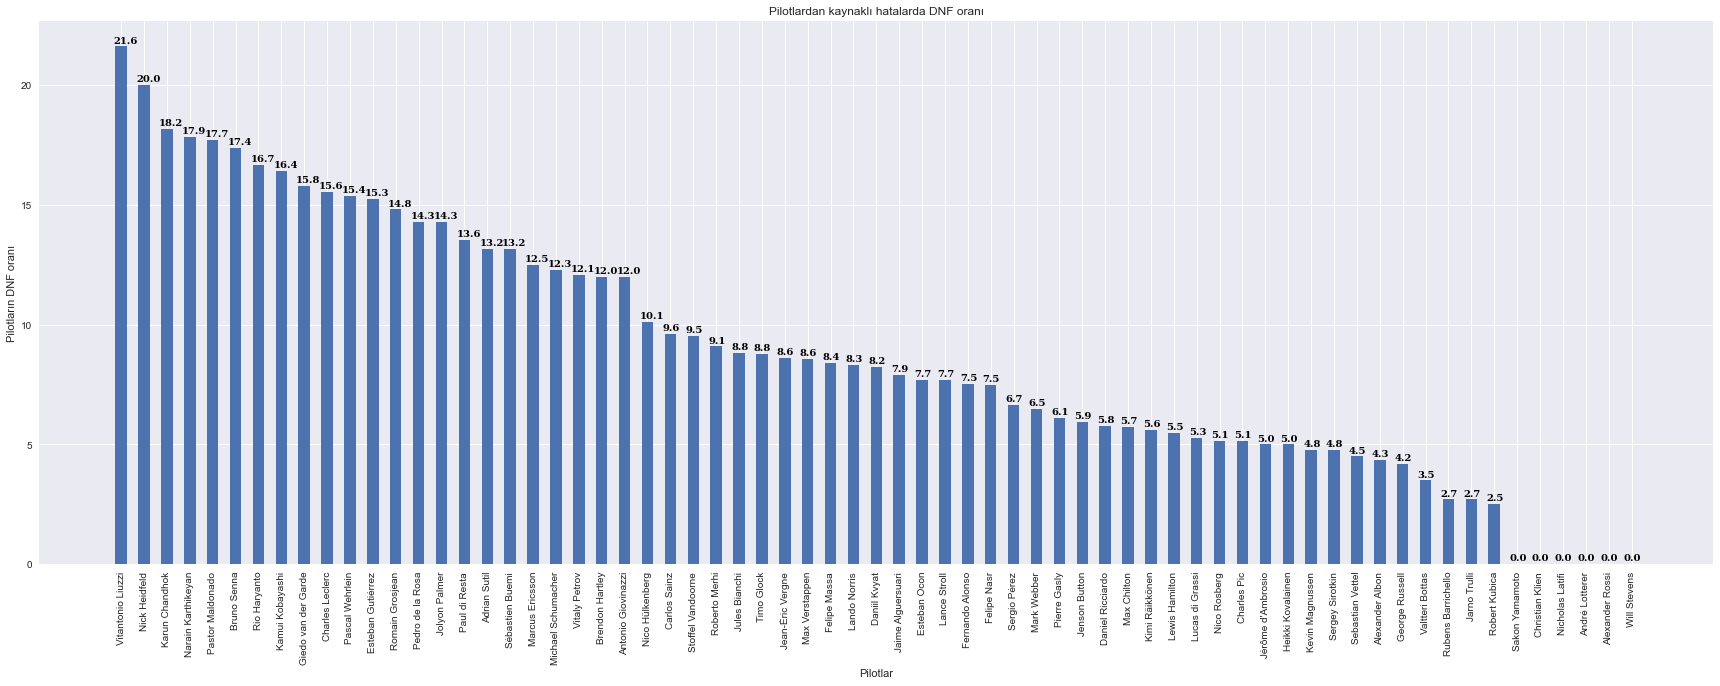

In [18]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}


dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Pilotlar')
plt.ylabel('Pilotların DNF oranı')
plt.title('Pilotlardan kaynaklı hatalarda DNF oranı')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

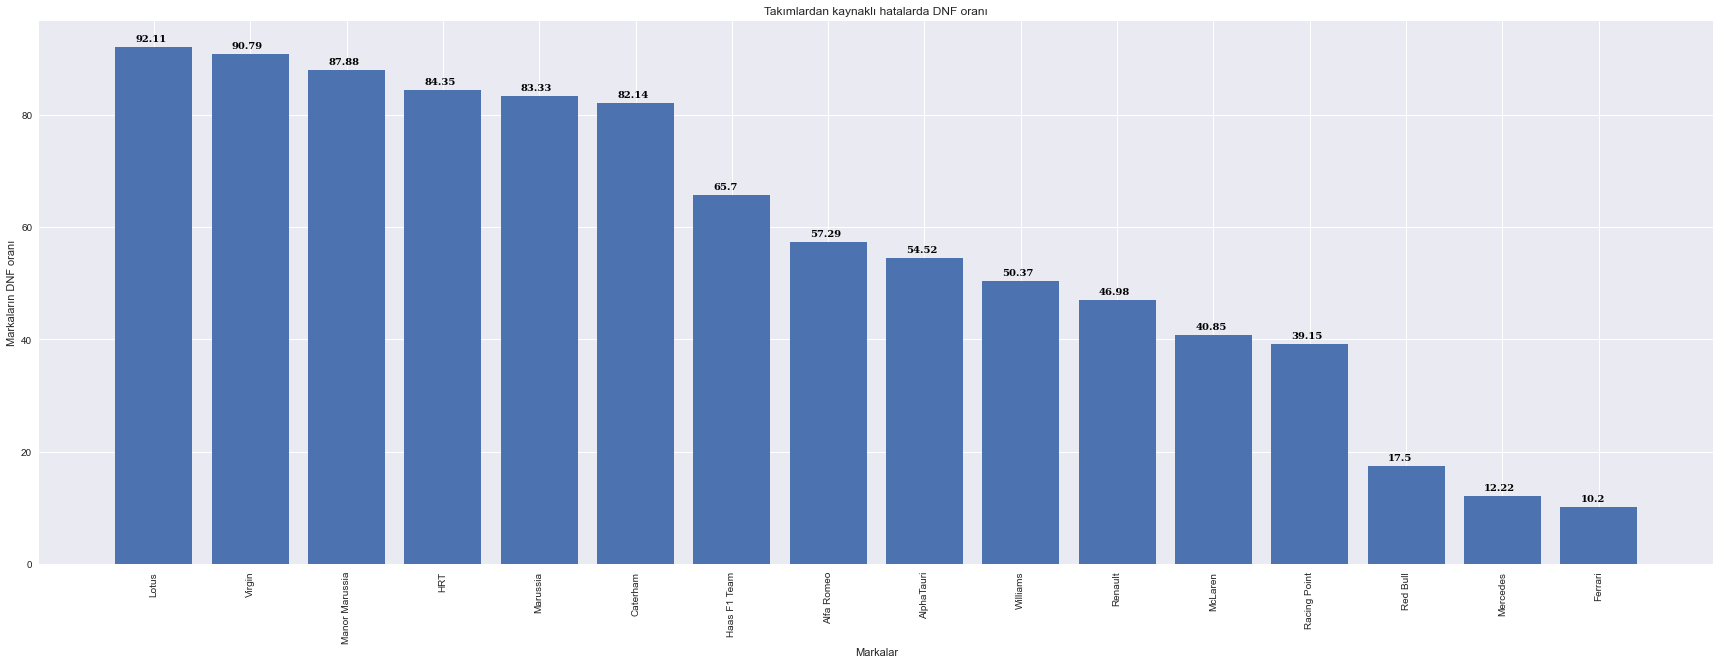

In [19]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Markalar')
plt.ylabel('Markaların DNF oranı')
plt.title('Takımlardan kaynaklı hatalarda DNF oranı')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()


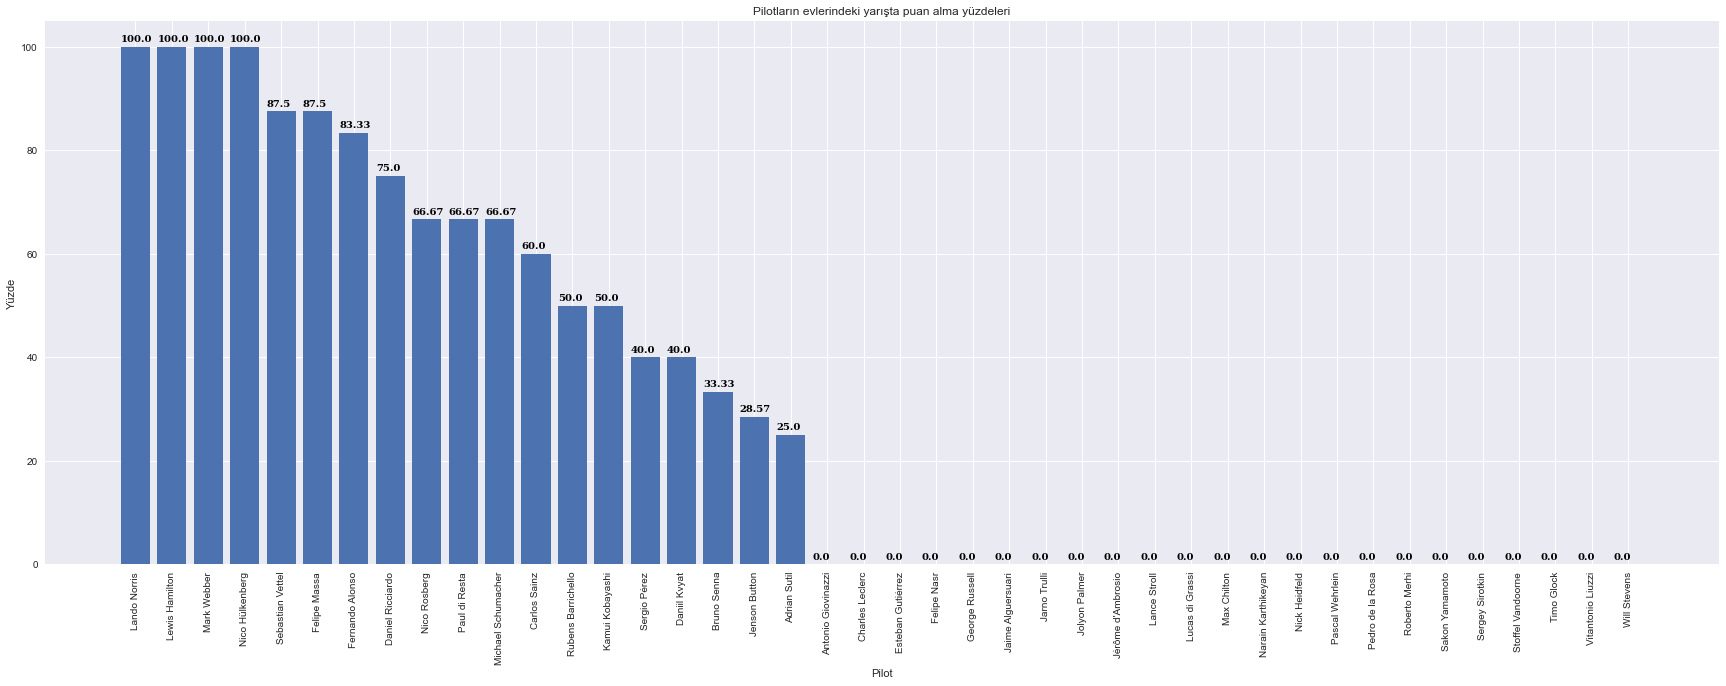

In [20]:
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Pilot')
plt.ylabel('Yüzde')
plt.title('Pilotların evlerindeki yarışta puan alma yüzdeleri')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

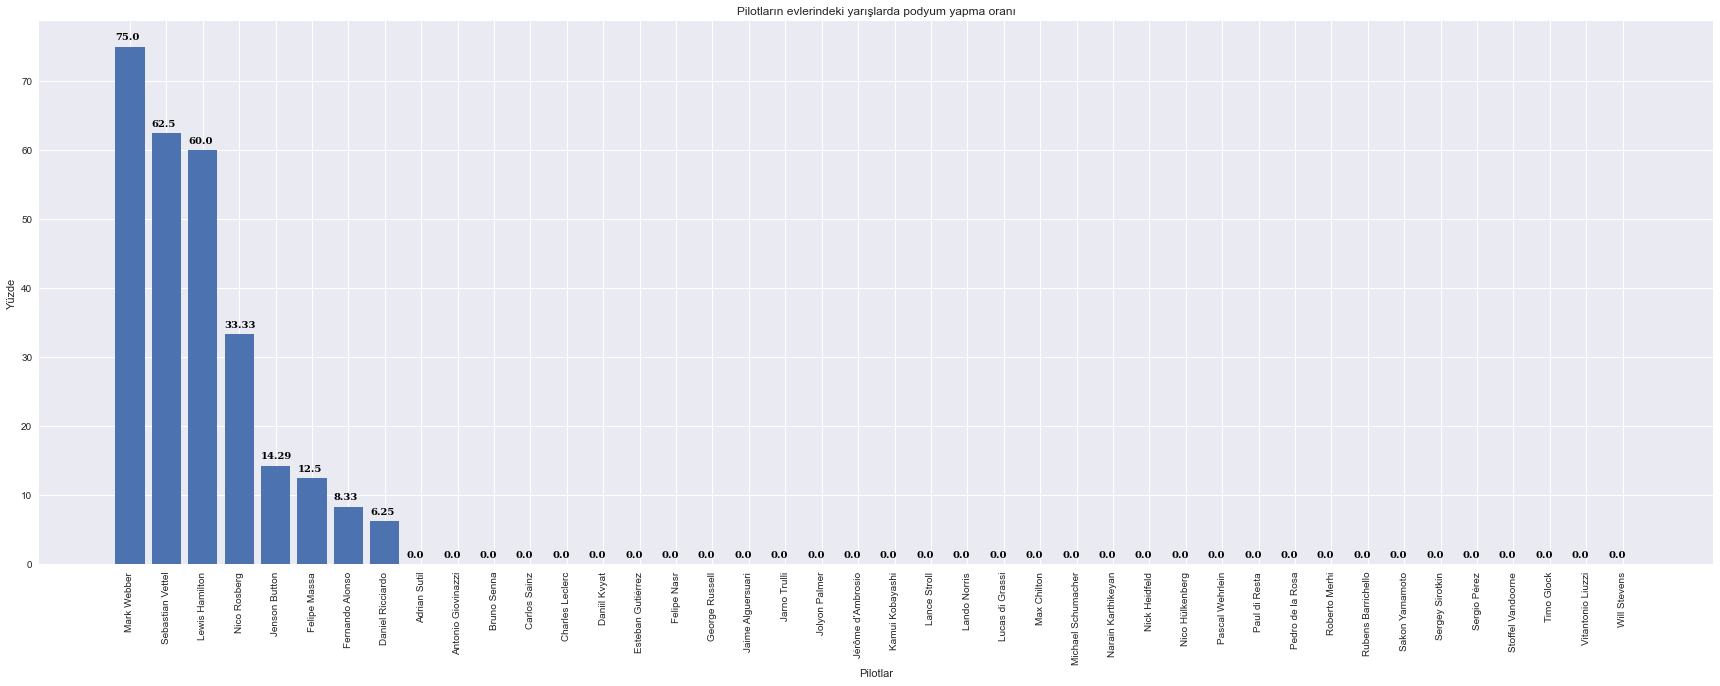

In [21]:
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Pilotlar')
plt.ylabel('Yüzde')
plt.title('Pilotların evlerindeki yarışlarda podyum yapma oranı')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

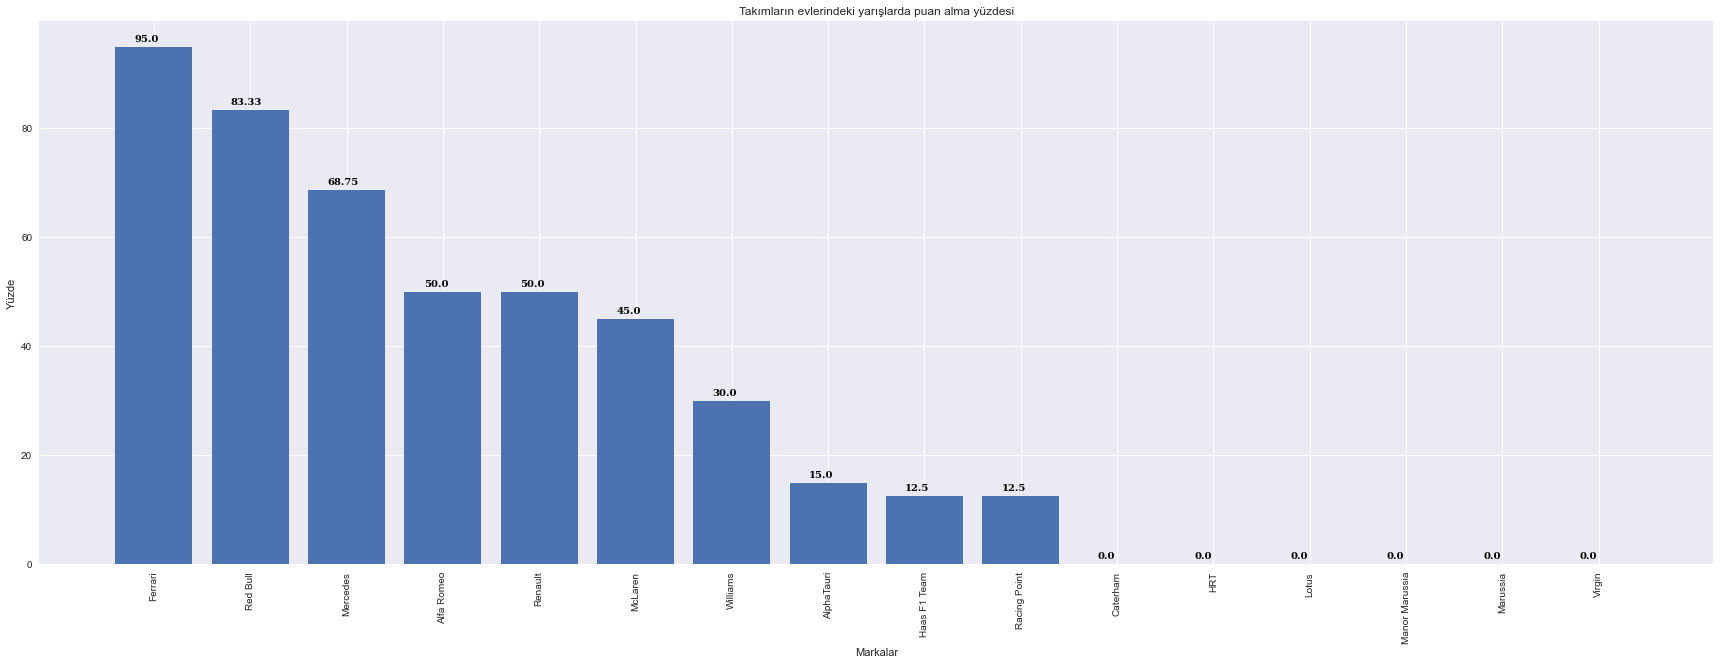

In [22]:
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Markalar')
plt.ylabel('Yüzde')
plt.title('Takımların evlerindeki yarışlarda puan alma yüzdesi')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

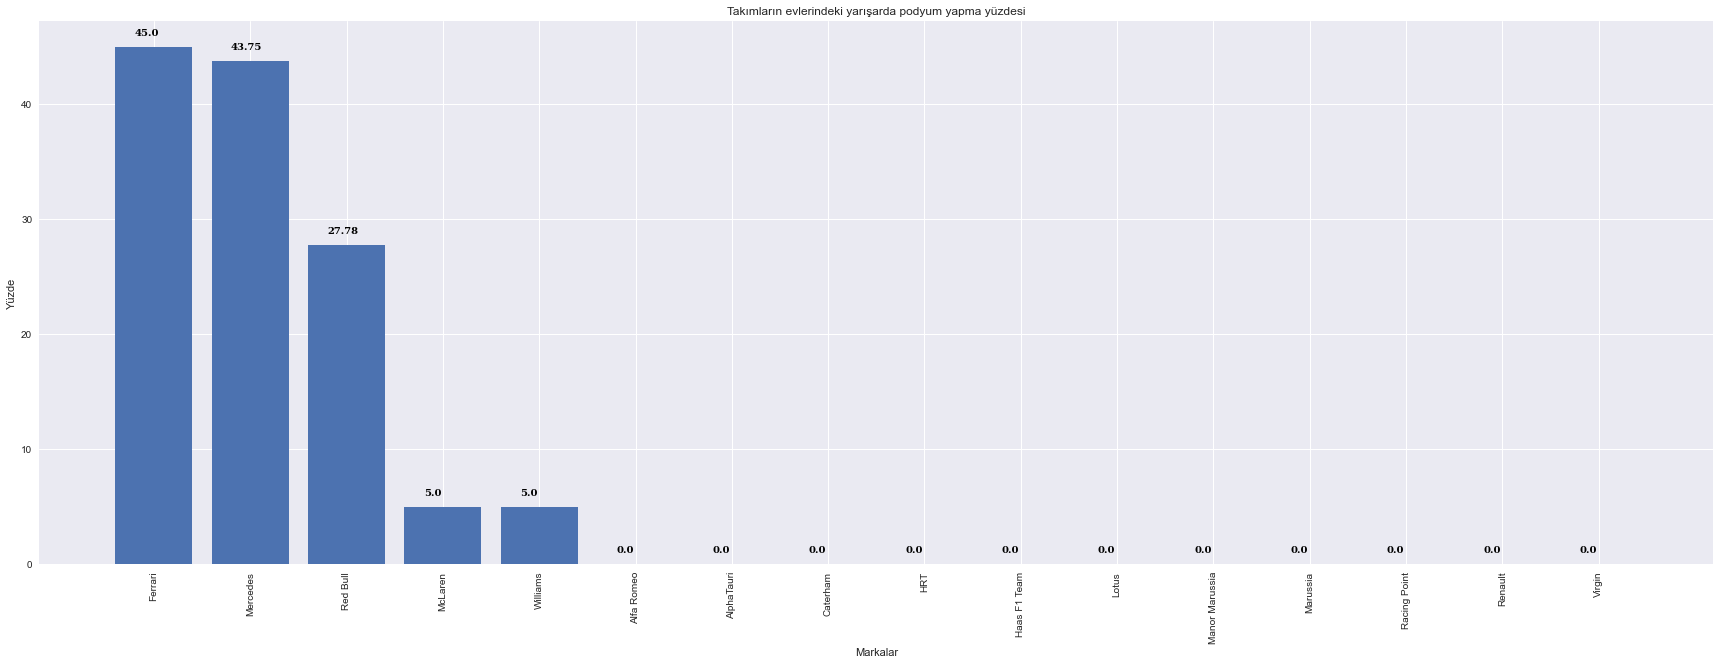

In [23]:
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Markalar')
plt.ylabel('Yüzde')
plt.title('Takımların evlerindeki yarışarda podyum yapma yüzdesi')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [24]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio 
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [25]:
print(driver_confidence)


driver
Adrian Sutil          0.868421
Alexander Albon       0.956522
Alexander Rossi       1.000000
André Lotterer        1.000000
Antonio Giovinazzi    0.880000
                        ...   
Timo Glock            0.912281
Valtteri Bottas       0.965035
Vitaly Petrov         0.879310
Vitantonio Liuzzi     0.783784
Will Stevens          1.000000
Name: driver_dnf, Length: 67, dtype: float64


In [26]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))

In [27]:
print(constructor_relaiblity)

constructor
Alfa Romeo        0.427136
AlphaTauri        0.454774
Caterham          0.178571
Ferrari           0.898010
HRT               0.156522
Haas F1 Team      0.343023
Lotus             0.078947
Manor Marussia    0.121212
Marussia          0.166667
McLaren           0.591479
Mercedes          0.877805
Racing Point      0.608479
Red Bull          0.825000
Renault           0.530151
Virgin            0.092105
Williams          0.496259
Name: constructor_dnf, dtype: float64


In [28]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_relaiblity'] = data['constructor'].apply(lambda x:constructor_relaiblity_dict[x])
#Emekli pilotları ve eski takımları cıkardık
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

*PİLOTLAR VE TAKIMLARI DÜŞÜNEREK MODEL HAZIRLAMA*

In [29]:
#Cleaned data adında istediğimiz nitelikleri seçerek bir dosya oluşturduk.
cleaned_data = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_relaiblity','active_driver','active_constructor','dob']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('cleaned_data.csv',index=False)

In [30]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [31]:
x=data[['GP_name','quali_pos','driver','age_at_gp_in_days','driver_confidence','active_driver','constructor','position','constructor_relaiblity','active_constructor']]

In [32]:
sc  = StandardScaler()
le = LabelEncoder()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
X = x.drop(['position'],1)



/var/folders/2p/jls_kbks2ps5z7245h_g4blm0000gn/T/ipykernel_6264/173885084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['GP_name'] = le.fit_transform(x['GP_name'])
/var/folders/2p/jls_kbks2ps5z7245h_g4blm0000gn/T/ipykernel_6264/173885084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['constructor'] = le.fit_transform(x['constructor'])
/var/folders/2p/jls_kbks2ps5z7245h_g4blm0000gn/T/ipykernel_6264/173885084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [33]:
y = x['position'].apply(lambda x: position_index(x))


In [34]:
x['position']

26      18
30       9
34      12
35       8
36      11
        ..
8130    20
8131    22
8132    22
8133    23
8134    21
Name: position, Length: 4323, dtype: int64

In [35]:
#Farklı modellerin doğrulanması
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_dri = []
results_dri = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10)
    result = cross_val_score(model,x,y,cv=cv,scoring='accuracy')
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

LogisticRegression : 0.900300444786588
DecisionTreeClassifier : 1.0
RandomForestClassifier : 1.0
SVC : 0.5350445855786503
GaussianNB : 0.9259745744589856
KNeighborsClassifier : 0.679389594559918


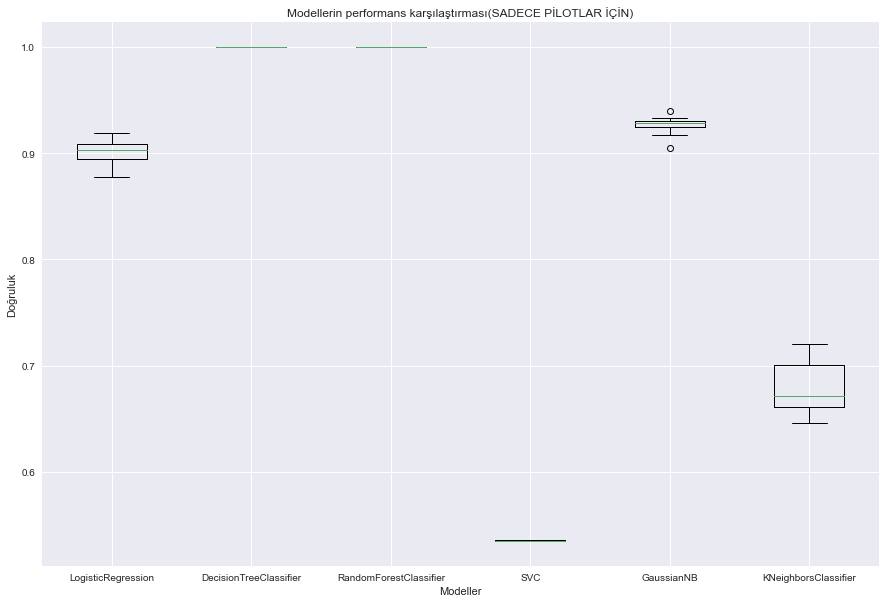

In [36]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_dri,labels=name)
plt.xlabel('Modeller')
plt.ylabel('Doğruluk')
plt.title('Modellerin performans karşılaştırması(SADECE PİLOTLAR İÇİN)')
plt.show()

*Sadece pilotlar*

In [37]:
x_d= data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver']]

In [38]:
x_d = x_d[x_d['active_driver']==1]

In [39]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [40]:
sc  = StandardScaler()
le = LabelEncoder()
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['driver'] = le.fit_transform(x_d['driver'])
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['age_at_gp_in_days'] = sc.fit_transform(x_d[['age_at_gp_in_days']])
X_d = x_d.drop(['position','active_driver'],1)
y_d = x_d['position'].apply(lambda x: position_index(x))

/var/folders/2p/jls_kbks2ps5z7245h_g4blm0000gn/T/ipykernel_6264/3348530896.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_d = x_d.drop(['position','active_driver'],1)


In [41]:
#Farklı modellerin doğrulanması
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_dri = []
results_dri = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10)
    result = cross_val_score(model,X_d,y_d,cv=cv,scoring='accuracy')
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

LogisticRegression : 0.9288897700237907
DecisionTreeClassifier : 0.9082791435368754
RandomForestClassifier : 0.9376473698123183
SVC : 0.9309436954797781
GaussianNB : 0.8655300026434048
KNeighborsClassifier : 0.9082817869415807


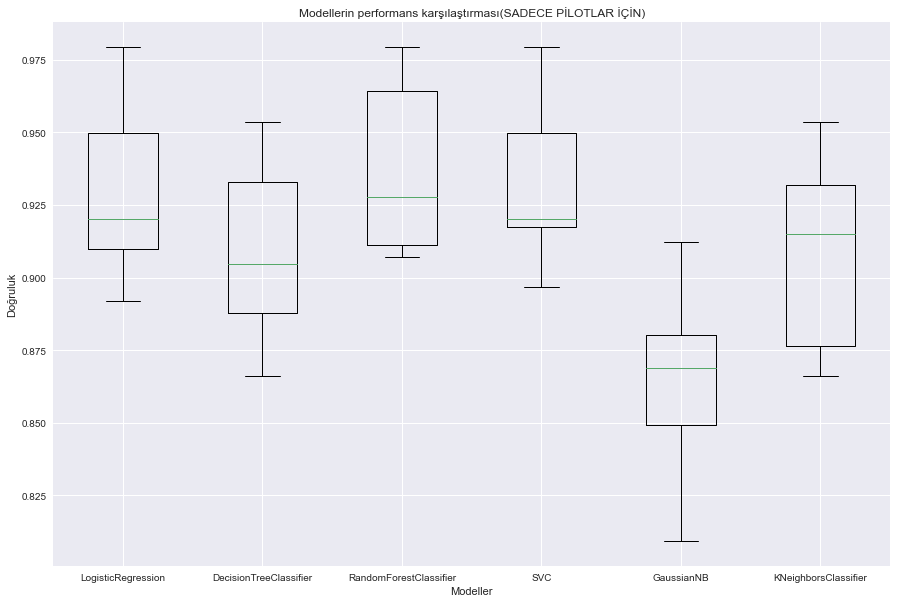

In [42]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_dri,labels=name)
plt.xlabel('Modeller')
plt.ylabel('Doğruluk')
plt.title('Modellerin performans karşılaştırması(SADECE PİLOTLAR İÇİN)')
plt.show()

### Sadece takımlar göz önünde alınarak

In [43]:
x_c = data[['GP_name','quali_pos','constructor','position','constructor_relaiblity','active_constructor']]

In [44]:
x_c = x_c[x_c['active_constructor']==1]

In [45]:
sc  = StandardScaler()
le = LabelEncoder()
x_c['GP_name'] = le.fit_transform(x_c['GP_name'])
x_c['constructor'] = le.fit_transform(x_c['constructor'])
X_c = x_c.drop(['position','active_constructor'],1)
y_c = x_c['position'].apply(lambda x: position_index(x))

/var/folders/2p/jls_kbks2ps5z7245h_g4blm0000gn/T/ipykernel_6264/666787451.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_c = x_c.drop(['position','active_constructor'],1)


In [46]:
#Modellerin karşılaştırılması
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
mean_results_const = []
results_const = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10)
    result = cross_val_score(model,X_c,y_c,cv=cv,scoring='accuracy')
    mean_results_const.append(result.mean())
    results_const.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

LogisticRegression : 0.9347480106100796
DecisionTreeClassifier : 0.9209549071618038
RandomForestClassifier : 0.9363395225464192
SVC : 0.9522546419098145
GaussianNB : 0.8665782493368699
KNeighborsClassifier : 0.9326259946949602


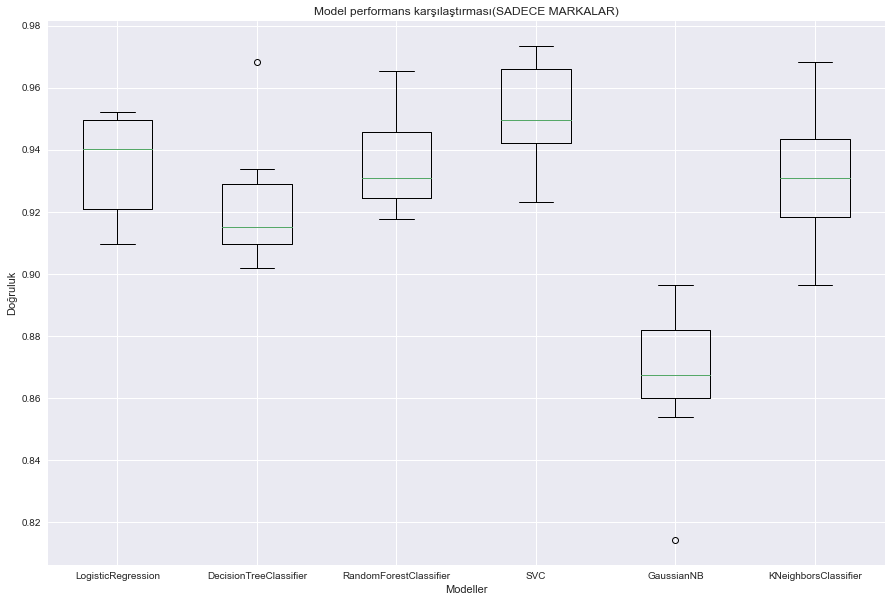

In [47]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_const,labels=name)
plt.xlabel('Modeller')
plt.ylabel('Doğruluk')
plt.title('Model performans karşılaştırması(SADECE MARKALAR)')
plt.show()

In [48]:
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
min_samples_split = [2,5,8,10,15,20]
min_samples_leaf = [1,2,4,6,8,10]
bootstrap = [True,False]

random_parms = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
                }

In [49]:
rf_rand = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf_rand,param_distributions=random_parms,n_iter=100,cv=10,verbose=2,n_jobs=-1)
rf_random.fit(X,y)
rf_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.1s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.2s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.5s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  14.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  14.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  14.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  15.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  15.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  15.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  18.7s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1800; total time=  19.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  13.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  14.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  14.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=1400; total time=  14.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  15.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  16.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  15.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  15.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  15.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  15.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  16.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  16.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   3.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  15.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1600; total time=  16.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   9.7s
[CV] END bootstrap=True, max_

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  20.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  20.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  21.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  21.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  21.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=400; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=10, min_samples_split=8, n_estimators=800; total time=   8.1s
[CV] END bootstrap=False, max_depth=60, 

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=   8.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=   8.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=   8.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   3.8s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   3.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   3.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   3.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=   8.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=   8.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   3.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   3.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  16.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  16.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  16.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  16.2s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  15.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   6.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1000; total time=   5.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   6.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   7.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  16.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  17.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   7.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   6.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   6.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   7.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   6.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   6.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   6.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1200; total time=   6.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=   9.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=  10.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=   9.8s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=  10.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=   9.8s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=  10.2s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=  10.1s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=  10.5s
[CV] END bootstrap=False, max_dept

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  10.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  10.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  10.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  10.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  10.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  10.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.6s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=800; total time=   4.5s
[CV] END bootstrap=True, max_depth=

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=  15.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=  16.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=  15.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=  16.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=  15.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=  15.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600; total time=   3.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=600; total time=   3.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=600; total time=   3.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=600; total time=   3.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.6s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1600; total time=   8.2s
[CV] END bootstrap=False, m

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=   8.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=   9.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=1600; total time=  16.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=   9.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=   8.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=   9.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=   9.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, ma

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1800; total time=  17.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1800; total time=  17.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1800; total time=  18.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1800; total time=  17.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1800; total time=  17.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  16.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  16.2s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1800; total time=  17.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1800; total time=  17.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  16.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  16.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  16.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  15.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  15.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  15.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=1600; total time=  15.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  17.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  17.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  17.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  18.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  17.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  17.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  17.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  18.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  17.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=1800; total time=  17.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.5s
[CV] END bootstrap=False, max_depth=50,

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1400; total time=   7.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1400; total time=   7.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1400; total time=   7.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1400; total time=   7.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1400; total time=   8.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1400; total time=   7.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  10.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  10.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  10.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   9.6s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  10.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  10.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  10.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   9.6s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  10.4s
[CV] END bootstrap=True, max_depth

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  19.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  18.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   5.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  18.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  18.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.5s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.4s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time=   6.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  17.9s
[CV] END bootstrap=False, max_dept

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  16.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  16.0s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  16.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   3.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   4.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  16.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  16.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   4.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   4.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   4.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   4.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   4.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   4.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   3.8s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  16.3s
[CV] END bootstrap=False, max_depth=1

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  15.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  15.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  15.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  15.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  16.1s
[CV] END bootstrap=False, max_depth=50, 

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   1.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   1.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  16.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  15.8s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  16.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1600; total time=  17.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   9.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   9.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   9.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  10.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   9.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   9.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   9.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   9.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=90, 

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   1.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   2.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   1.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   2.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   9.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  10.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1600; total time=   8.7s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1600; total time=   8.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1600; total time=   8.5s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1600; total time=   8.3s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1600; total time=   8.9s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1600; total time=   8.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1000; total time=   5.2s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1600; total time=   8.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1600; total time=   8.9s
[CV] END bootstrap=True, max_

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1400; total time=   7.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1400; total time=   7.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1400; total time=   7.3s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1400; total time=   7.5s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1400; total time=   7.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1400; total time=   7.7s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1400; total time=   7.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1400; total time=   7.6s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=800; total time=   4.5s
[CV] END bootstrap=True, max_depth=60, 

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=400; total time=   2.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1200; total time=  11.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1200; total time=  12.0s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1200; total time=  11.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1200; total time=  12.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   9.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=  10.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   9.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   9.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=  10.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   9.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=  10.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   9.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   9.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   9.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=   9.9s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=   9.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=   9.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=  10.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=  10.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=  10.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=  10.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=   9.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=   9.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=1800; total time=   9.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1600; total time=  15.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1600; total time=  16.4s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1600; total time=  16.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1600; total time=  16.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1600; total time=  15.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1600; total time=  16.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.4s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time=   4.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=400; total time=   2.2s
[CV] END bootstrap=False, max_depth=90, ma

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   2.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   3.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   3.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   3.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   3.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time=   2.9s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=70,

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=400; total time=   4.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1800; total time=  17.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1800; total time=  17.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=400; total time=   3.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=   9.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1400; total time=   7.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1400; total time=   7.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1400; total time=   7.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1400; total time=   7.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  10.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1400; total time=   7.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1400; total time=   7.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=20, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=20, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=20, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=20, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=40,

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=20, n_estimators=600; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1400; total time=   7.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1400; total time=   7.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   1.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=20, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=20, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=100, m

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=20, n_estimators=1200; total time=   6.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   8.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   9.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=20, n_estimators=1200; total time=   6.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=20, n_estimators=1200; total time=   6.4s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=20, n_estimators=1200; total time=   6.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=20, n_estimators=1200; total time=   6.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=   6.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=   6.7s
[CV] END bootstrap=False, max_dept

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=   7.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=   6.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=   6.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=   6.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=   6.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=   6.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  17.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  11.7s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  11.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  12.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  11.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  11.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=1800; total time=  18.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  12.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  11.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  12.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  11.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; total time=  12.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=  10.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=  10.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=  10.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=  10.3s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=  10.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=   9.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=  10.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=  10.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=  10.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000; total time=   9.9s
[CV] END bootstrap=True, ma

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   4.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   4.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   4.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   4.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   4.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   4.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   4.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   8.2s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   8.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   8.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   7.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   8.2s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   8.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   8.4s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   7.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   7.7s
[CV] END bootstrap=F

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1600; total time=   8.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1600; total time=   8.5s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1600; total time=   9.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1600; total time=   8.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=800; total time=   4.3s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=800; total time=   4.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=800; total time=   4.3s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=800; total time=   4.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=800; total time=   4.5s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=800; total time=   4.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1600; total time=   8.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1600; total time=   8.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=800; total time=   4.1s
[CV] END bootstrap=True, max_depth=110

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   3.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.6s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.0s
[CV] END bootstrap=True, max_depth

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=  10.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=  10.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=  10.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=  10.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=  10.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=  10.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  10.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  11.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  11.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  11.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  11.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  11.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  11.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  11.5s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  10.9s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=  11.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  15.9s
[CV] END bootstrap=False, max_dept

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  15.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=1600; total time=  16.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  16.0s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  15.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  16.2s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  15.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  16.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  16.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  15.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  16.2s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  15.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1600; total time=  15.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1800; total time=   9.3s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1800; total time=  10.1s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1800; total time=   9.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1800; total time=  10.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1800; total time=  10.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1800; total time=  10.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.7s
[CV] END bootstrap=True, max_dept

/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=1800; total time=  10.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.7s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=600; total time=   3.8s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   6.9s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   7.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   6.6s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   6.7s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   6.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   6.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   5.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   5.7s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   4.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600; total time=   4.4s


/Users/umutakpolat/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 1800,
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [50]:
rf = RandomForestClassifier(n_estimators=1600,min_samples_split=20,min_samples_leaf=1,max_features='sqrt',max_depth=90,bootstrap=True)
kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)#10 parçaya böldük
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

In [51]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
cnf_mat_rf = confusion_matrix(y_test,y_pred_rf)
cnf_mat_rf = cnf_mat_rf/cnf_mat_rf.sum()